# Análise - Impacto da COVID-19 na Disponibilidade de Leitos em Diferentes Períodos da Pandemia

Pergunta de Negócio: 
- "Quais estados apresentaram maior taxa de mortalidade e quantidade total de casos de COVID-19 ao longo do tempo?"

Objetivo: 
- Essa análise permite avaliar o impacto da COVID-19 em diferentes estados, considerando tanto o número absoluto de óbitos quanto a relação desses óbitos com o número de casos. Isso possibilita identificar estados onde a taxa de mortalidade foi proporcionalmente mais alta em relação aos casos confirmados. Permitindo comparar a gravidade do contágio entre os estados, fornecendo insights sobre a capacidade de resposta e vulnerabilidade das populações em cada região.

In [1]:
import pandas as pd

tabelas=[ 'brazil_cities_coordinates.csv'
         , 'brazil_covid19_cities.csv']

for item in tabelas:
    df = pd.read_csv(item, encoding='UTF-8')
    #df.head(10)
    print(f"\ntabela: {item}")
    print(df.dtypes)


tabela: brazil_cities_coordinates.csv
state_code      int64
city_code       int64
city_name      object
lat           float64
long          float64
capital          bool
dtype: object

tabela: brazil_covid19_cities.csv
date       object
state      object
name       object
code      float64
cases     float64
deaths      int64
dtype: object


## Preparar os dados

#### Separando as Tabelas para o CASSANDRA

In [2]:
import csv
import pandas as pd

def preparar_df(file_entrada, file_saida, colunas):
    with open(file_entrada, 'r', newline='', encoding='utf-8') as input_file, \
         open(file_saida, 'w', newline='', encoding='utf-8') as output_file:
        reader = csv.reader(input_file)
        writer = csv.writer(output_file)
        
        header = next(reader)  # Lê o cabeçalho do arquivo de entrada
        writer.writerow([col[0] for col in colunas])  # Escreve o cabeçalho no arquivo de saída
        
        for row in reader:
            if len(row) > max(idx for name, idx in colunas):  # Verifica se há colunas suficientes
                valores = []
                for name, idx in colunas:
                    valor = row[idx]
                    if file_entrada == 'brazil_cities_coordinates.csv' and name == 'ddd':  # Converte e remove o último dígito
                        valor = int(float(valor)) // 10
                    elif name in ['ddd', 'casos', 'mortes']:  # Converte casos e mortes para inteiro
                        valor = int(float(valor))
                    elif name == 'capital':  # Converte a coluna 'capital' para minúsculo
                        valor = valor.lower()
                    valores.append(valor)
                writer.writerow(valores)

preparar_df(
    file_entrada='brazil_covid19_cities.csv',
    file_saida='casos_mortes_por_cidade_data.csv',
    colunas=[
        ('ddd', 3),
        ('data', 0),
        ('nome_cidade', 2),
        ('estado', 1),
        ('casos', 4),
        ('mortes', 5)
    ]
)

df = pd.read_csv('casos_mortes_por_cidade_data.csv')
df_acumulado = df.groupby(['ddd', 'nome_cidade', 'estado']).agg({
    'casos': 'sum',
    'mortes': 'sum'
}).reset_index()

df_acumulado.to_csv('casos_mortes_acumulados_por_cidade.csv', index=False)

preparar_df(
    file_entrada='brazil_cities_coordinates.csv',
    file_saida='cidades_capitais.csv',
    colunas=[
        ('ddd', 1),
        ('nome_cidade', 2),
        ('capital', 5)
    ]
)

df_casos_mortes = pd.read_csv('casos_mortes_por_cidade_data.csv')
df_localizacao = pd.read_csv('cidades_capitais.csv')

# Tratando Bools para Cassandra
df_localizacao['capital'] = df_localizacao['capital'].astype(str).str.lower()

# JOIN VAR FLAG_CAPITAL
df_merged = pd.merge(
    df_casos_mortes, 
    df_localizacao[['ddd', 'capital']], 
    on='ddd', 
    how='left'
)

df_merged.to_csv('casos_mortes_por_cidade_data_capital.csv', index=False)


## Cassandra

docker run -it --rm --name cassandra1 --network cassandra -P -e CASSANDRA_CLUSTER_NAME=Cluster1 -v "C:\Users\jean_\OneDrive\Pos-Graduação-MIT-Engenharia-de-Dados\Aulas\01-Infraestrutura-Cassandra\Projetos\Aula-6\dados:/tmp/dados" cassandra:latest

docker exec -it cassandra1 bash

CREATE KEYSPACE avaliacao_cassandra WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};  
use avaliacao_cassandra;

CREATE TABLE casos_mortes_por_cidade_data_capital (
    ddd INT,
    data DATE,
    nome_cidade TEXT,
    estado TEXT,
    casos FLOAT,
    mortes INT,
    capital BOOLEAN,
    PRIMARY KEY ((ddd), data)
) WITH CLUSTERING ORDER BY (data DESC);
COPY avaliacao_cassandra.casos_mortes_por_cidade_data_capital (ddd, data, nome_cidade, estado, casos, mortes, capital) FROM '/tmp/dados/prova/COVID/casos_mortes_por_cidade_data_capital.csv' WITH HEADER = true;

CREATE TABLE casos_mortes_acumulados_por_cidade (
    ddd INT,
    nome_cidade TEXT,
    estado TEXT,
    casos FLOAT,
    mortes INT,
    PRIMARY KEY (ddd)
);
COPY avaliacao_cassandra.casos_mortes_acumulados_por_cidade (ddd, nome_cidade, estado, casos, mortes) FROM '/tmp/dados/prova/COVID/casos_mortes_acumulados_por_cidade.csv' WITH HEADER = true;


## Analise

### Spark Session e Métodos

In [3]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [5]:
import findspark

findspark.init('../../spark-3.5.3-bin-hadoop3')

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('Analises de Streaming') \
    .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.5.1') \
    .config('spark.cassandra.connection.host', 'cassandra1') \
    .config('spark.cassandra.connection.port', '9042') \
    .getOrCreate()

print(f"Versão Spark....: {spark.version}")
print(f"Versão Cassandra: 5.0.1")
print(f"Versão do Scala.: 2.12.18")

Versão Spark....: 3.5.3
Versão Cassandra: 5.0.1
Versão do Scala.: 2.12.18


#### Métodos

In [8]:
def import_tabela_cassandra( tabela_cassandra, keyspace='avaliacao_cassandra'):
    
    tabela = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table=tabela_cassandra, keyspace=keyspace) \
    .load()

    return tabela

### T1 - casos_mortes_por_cidade_data_capital

In [9]:
tabela = 'casos_mortes_por_cidade_data_capital'

globals()[tabela] = import_tabela_cassandra(tabela)
globals()[tabela].createOrReplaceTempView(tabela)
globals()[tabela].printSchema()
#globals()[tabela].show(5)

root
 |-- ddd: integer (nullable = false)
 |-- data: date (nullable = true)
 |-- capital: boolean (nullable = true)
 |-- casos: float (nullable = true)
 |-- estado: string (nullable = true)
 |-- mortes: integer (nullable = true)
 |-- nome_cidade: string (nullable = true)



#### Gráfico Dispersão - Relação entre Casos e Mortes de COVID-19 nas Cidades por Estado

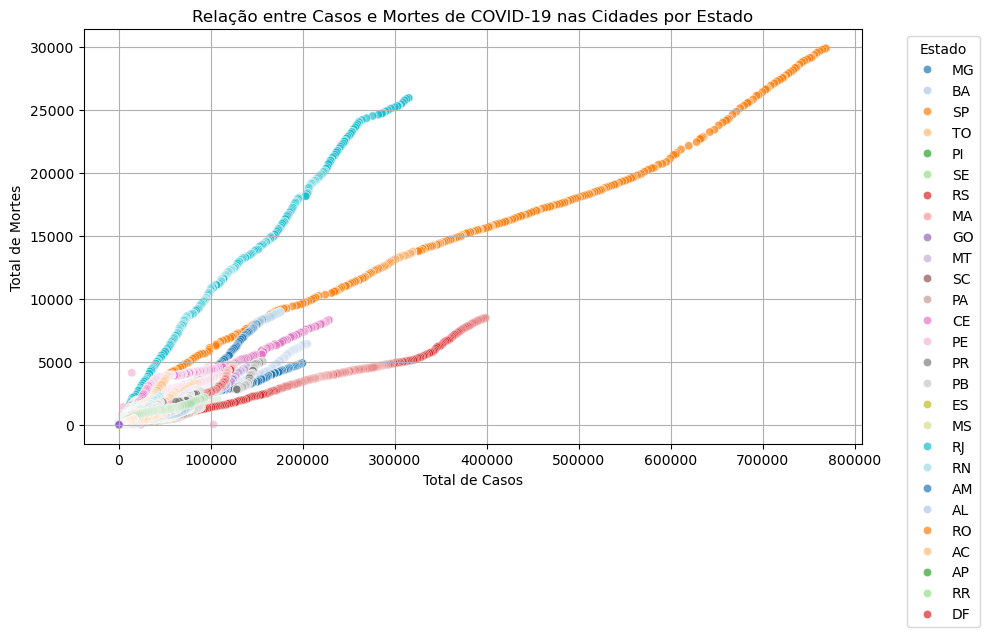

In [12]:
df = casos_mortes_por_cidade_data_capital.toPandas()

plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='casos', y='mortes', hue='estado', palette='tab20', alpha=0.7)

plt.xlabel("Total de Casos")
plt.ylabel("Total de Mortes")
plt.title("Relação entre Casos e Mortes de COVID-19 nas Cidades por Estado")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Estado')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Gráfico Linha - Média Mensal de Contágio e Mortes de COVID-19: Capitais vs Cidades Comuns

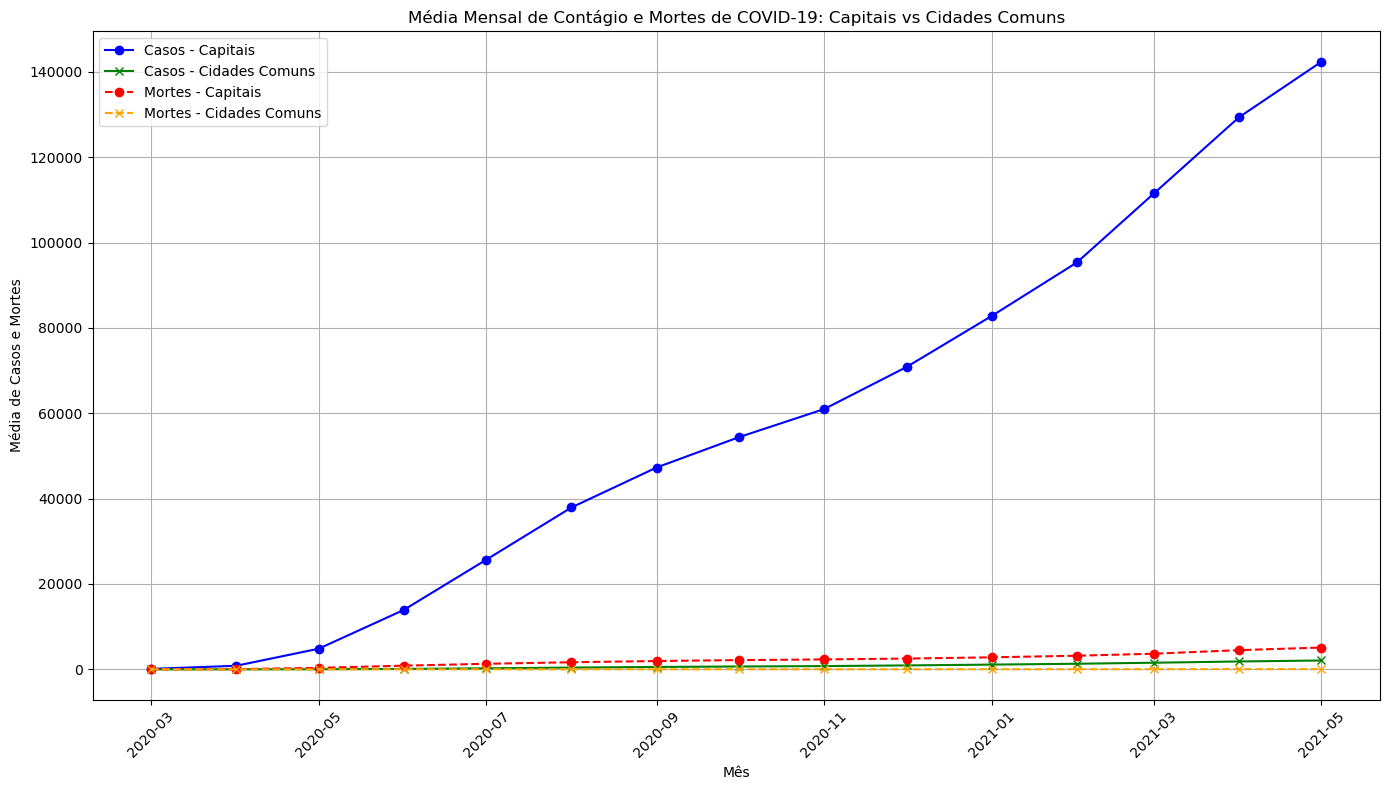

In [13]:
import matplotlib.pyplot as plt

# Consultas para média de contágio mensal
media_mensal_capitais = spark.sql("""
SELECT 
    date_trunc('month', data) AS mes,
    AVG(casos) AS media_mensal_casos_capitais
FROM 
    casos_mortes_por_cidade_data_capital
WHERE 
    capital = 'True'
GROUP BY 
    date_trunc('month', data)
ORDER BY 
    mes
""")

media_mensal_cidades_comuns = spark.sql("""
SELECT 
    date_trunc('month', data) AS mes,
    AVG(casos) AS media_mensal_casos_cidades_comuns
FROM 
    casos_mortes_por_cidade_data_capital
WHERE 
    capital = 'False'
GROUP BY 
    date_trunc('month', data)
ORDER BY 
    mes
""")

# Consultas para média de mortes mensal
media_mensal_mortes_capitais = spark.sql("""
SELECT 
    date_trunc('month', data) AS mes,
    AVG(mortes) AS media_mensal_mortes_capitais
FROM 
    casos_mortes_por_cidade_data_capital
WHERE 
    capital = 'True'
GROUP BY 
    date_trunc('month', data)
ORDER BY 
    mes
""")

media_mensal_mortes_cidades_comuns = spark.sql("""
SELECT 
    date_trunc('month', data) AS mes,
    AVG(mortes) AS media_mensal_mortes_cidades_comuns
FROM 
    casos_mortes_por_cidade_data_capital
WHERE 
    capital = 'False'
GROUP BY 
    date_trunc('month', data)
ORDER BY 
    mes
""")

# Convertendo para Pandas
df_capitais = media_mensal_capitais.toPandas()
df_cidades_comuns = media_mensal_cidades_comuns.toPandas()
df_mortes_capitais = media_mensal_mortes_capitais.toPandas()
df_mortes_cidades_comuns = media_mensal_mortes_cidades_comuns.toPandas()

plt.figure(figsize=(14, 8))

plt.plot(df_capitais['mes'], df_capitais['media_mensal_casos_capitais'], marker='o', color='blue', label="Casos - Capitais")
plt.plot(df_cidades_comuns['mes'], df_cidades_comuns['media_mensal_casos_cidades_comuns'], marker='x', color='green', label="Casos - Cidades Comuns")
plt.plot(df_mortes_capitais['mes'], df_mortes_capitais['media_mensal_mortes_capitais'], marker='o', linestyle='--', color='red', label="Mortes - Capitais")
plt.plot(df_mortes_cidades_comuns['mes'], df_mortes_cidades_comuns['media_mensal_mortes_cidades_comuns'], marker='x', linestyle='--', color='orange', label="Mortes - Cidades Comuns")

plt.title("Média Mensal de Contágio e Mortes de COVID-19: Capitais vs Cidades Comuns")
plt.xlabel("Mês")
plt.ylabel("Média de Casos e Mortes")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


### T2 - casos_mortes_acumulados_por_cidade

In [14]:
tabela = 'casos_mortes_acumulados_por_cidade'

globals()[tabela] = import_tabela_cassandra(tabela)
globals()[tabela].createOrReplaceTempView(tabela)
globals()[tabela].printSchema()
#globals()[tabela].show(5)

root
 |-- ddd: integer (nullable = false)
 |-- casos: float (nullable = true)
 |-- estado: string (nullable = true)
 |-- mortes: integer (nullable = true)
 |-- nome_cidade: string (nullable = true)



#### Gráfico Barra - Top 10 Cidades Brasileiras com Mais Casos e Mortes Acumuladas de COVID-19

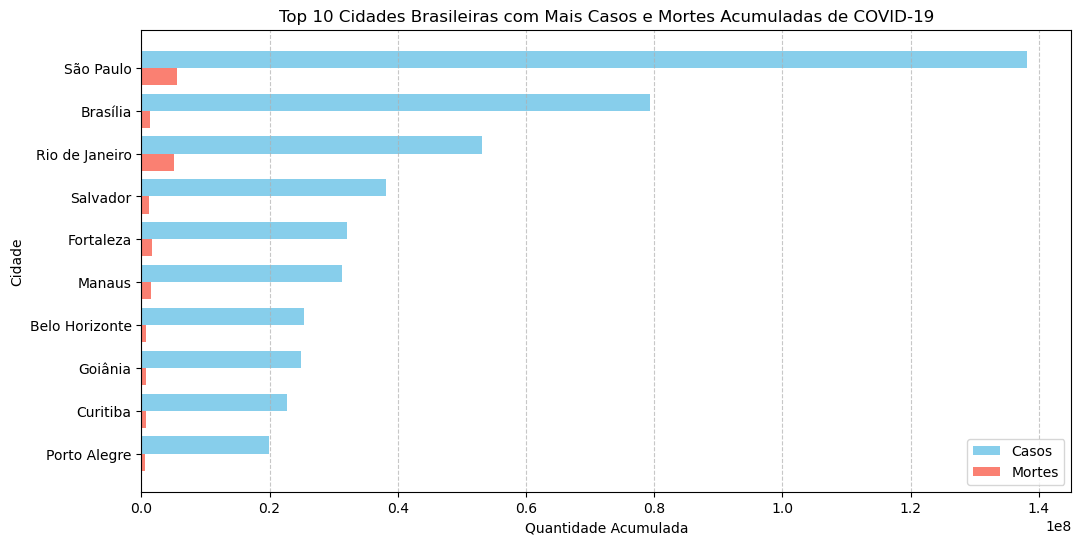

In [16]:
import matplotlib.pyplot as plt
import numpy as np

Q2 = spark.sql(f"""
SELECT 
     ddd
    , nome_cidade
    , estado
    , casos
    , mortes
FROM 
    casos_mortes_acumulados_por_cidade
ORDER BY 
    casos DESC
LIMIT 10""")

df = Q2.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4
indices = np.arange(len(df))

ax.barh(indices - bar_width / 2, df['casos'], height=bar_width, color='skyblue', label='Casos')
ax.barh(indices + bar_width / 2, df['mortes'], height=bar_width, color='salmon', label='Mortes')

# Configurações dos eixos e rótulos
ax.set_yticks(indices)
ax.set_yticklabels(df['nome_cidade'])
ax.set_xlabel("Quantidade Acumulada")
ax.set_ylabel("Cidade")
ax.set_title("Top 10 Cidades Brasileiras com Mais Casos e Mortes Acumuladas de COVID-19")
ax.invert_yaxis()  # Inverter o eixo y para mostrar a cidade com mais casos no topo
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.show()
